In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import warnings
from tqdm import tqdm
warnings.filterwarnings( 'ignore' )

import matplotlib.pyplot as plt
import os 
import sys
import time
import seaborn as sns
import math
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'phmap_train'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/phmap_train


In [ ]:
file_list = os.listdir('/content/drive/My Drive/'+FOLDERNAME)

path = '/content/drive/MyDrive/phmap_train'
print(file_list)

['train_1st_Bearing.csv', 'train_1st_high.csv', 'train_1st_Looseness.csv', 'train_1st_Normal.csv', 'train_1st_Unbalance.csv', 'train_2nd_Bearing.csv', 'train_2nd_Looseness.csv', 'train_2nd_Unbalance.csv', 'train_3rd_Normal.csv', 'train_3rd_Unbalance.csv', 'gtzan-dataset-music-genre-classification.zip', 'Data', '데이터 갖고놀기', '실습1.ipynb']


In [ ]:
def Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):

  #Normal[label 0] → Fault-free operating condition
  #Unbalance[label 1] → Unbalance between centers of mass and axis
  #Belt-Looseness[label 2] → Looseness of V‐belt connecting between motor pully and screw pully
  #Belt-Looseness High[label 3] → High Looseness of V-belt
  #Bearing fault[label 4] → Removing grease of Ball Bearing on Motor, which induces its wear-out

  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))-128
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in tqdm(range(Number_of_data)):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  ds = tf.data.Dataset.from_tensor_slices((data_array ,label))
  return ds

def TEST_Dataset_Constructor(df, time_series_length = 128, NumofChannel = 2, label = None, window = 128):
  Number_of_data = int(df.shape[0]/(time_series_length -( 128 - window )))
  data_array = np.zeros((Number_of_data, time_series_length, NumofChannel))
  label = np.full_like(np.zeros((Number_of_data)), label)
  for i in range(Number_of_data):
    data_array[i]= df.iloc[window*(i) : window*i+128,: ].values
  return tf.convert_to_tensor(data_array)
  


In [ ]:
train_1st_Bearing = pd.read_csv(os.path.join(path, file_list[0]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Looseness = pd.read_csv(os.path.join(path, file_list[1]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Normal = pd.read_csv(os.path.join(path, file_list[2]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_Unbalance = pd.read_csv(os.path.join(path, file_list[3]),float_precision = 'round_trip').iloc[:, 1:]
train_1st_high = pd.read_csv(os.path.join(path, file_list[4]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Bearing = pd.read_csv(os.path.join(path, file_list[5]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Looseness = pd.read_csv(os.path.join(path, file_list[6]),float_precision = 'round_trip').iloc[:, 1:]
train_2nd_Unbalance = pd.read_csv(os.path.join(path, file_list[7]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Normal = pd.read_csv(os.path.join(path, file_list[8]),float_precision = 'round_trip').iloc[:, 1:]
train_3rd_Unbalance = pd.read_csv(os.path.join(path, file_list[9]),float_precision = 'round_trip').iloc[:, 1:]


In [ ]:

Bearing1st_ds = Dataset_Constructor(train_1st_Bearing, label = 4 )
Looseness1st_ds = Dataset_Constructor(train_1st_Looseness,label = 2,window = 90)
Normal1st_ds = Dataset_Constructor(train_1st_Normal, label = 0 )
Unbalance1st_ds = Dataset_Constructor(train_1st_Unbalance, label = 1)
High1st_ds = Dataset_Constructor(train_1st_high, label = 3, window = 18)

100%|██████████| 654302/654302 [00:35<00:00, 18195.77it/s]


In [ ]:

Bearing2nd_ds = Dataset_Constructor(train_2nd_Bearing, label = 4 )
Looseness2nd_ds = Dataset_Constructor(train_2nd_Looseness,label = 2,window = 90)
Unbalance2nd_ds = Dataset_Constructor(train_2nd_Unbalance, label = 1)
Normal3rd_ds = Dataset_Constructor(train_3rd_Normal, label = 0)
Unbalance3rd_ds = Dataset_Constructor(train_3rd_Unbalance, label = 1)

100%|██████████| 184375/184375 [00:10<00:00, 18080.23it/s]


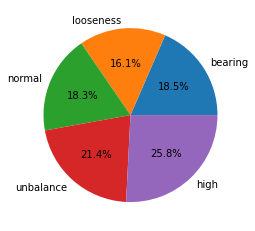

In [ ]:
bearing = Bearing1st_ds.__len__().numpy() + Bearing2nd_ds.__len__().numpy()
looseness = Looseness1st_ds.__len__().numpy() + Looseness2nd_ds.__len__().numpy()
normal = Normal1st_ds.__len__().numpy() + Normal3rd_ds.__len__().numpy()
unbalance = Unbalance1st_ds.__len__().numpy() + Unbalance2nd_ds.__len__().numpy() + Unbalance3rd_ds.__len__().numpy()
high = High1st_ds.__len__().numpy()

plt.pie([bearing,looseness,normal,unbalance,high], labels=['bearing','looseness','normal','unbalance','high'], autopct='%.1f%%')
plt.show()

In [ ]:
Dataset = Bearing1st_ds.concatenate(Looseness1st_ds).concatenate(Normal1st_ds).concatenate(Unbalance1st_ds).concatenate(High1st_ds).concatenate(Bearing2nd_ds).concatenate(Looseness2nd_ds).concatenate(Unbalance2nd_ds).concatenate(Normal3rd_ds).concatenate(Unbalance3rd_ds).shuffle(buffer_size = 4518720, seed = 42).batch(256).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
Dataset.__len__().numpy()

9905

In [ ]:
Dataset.unbatch()

<_UnbatchDataset shapes: ((128, 2), ()), types: (tf.float64, tf.float64)>

In [ ]:
Dataset

<PrefetchDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
Valid_Dataset = Dataset.take(1000) 
Train_Dataset = Dataset.skip(1000)

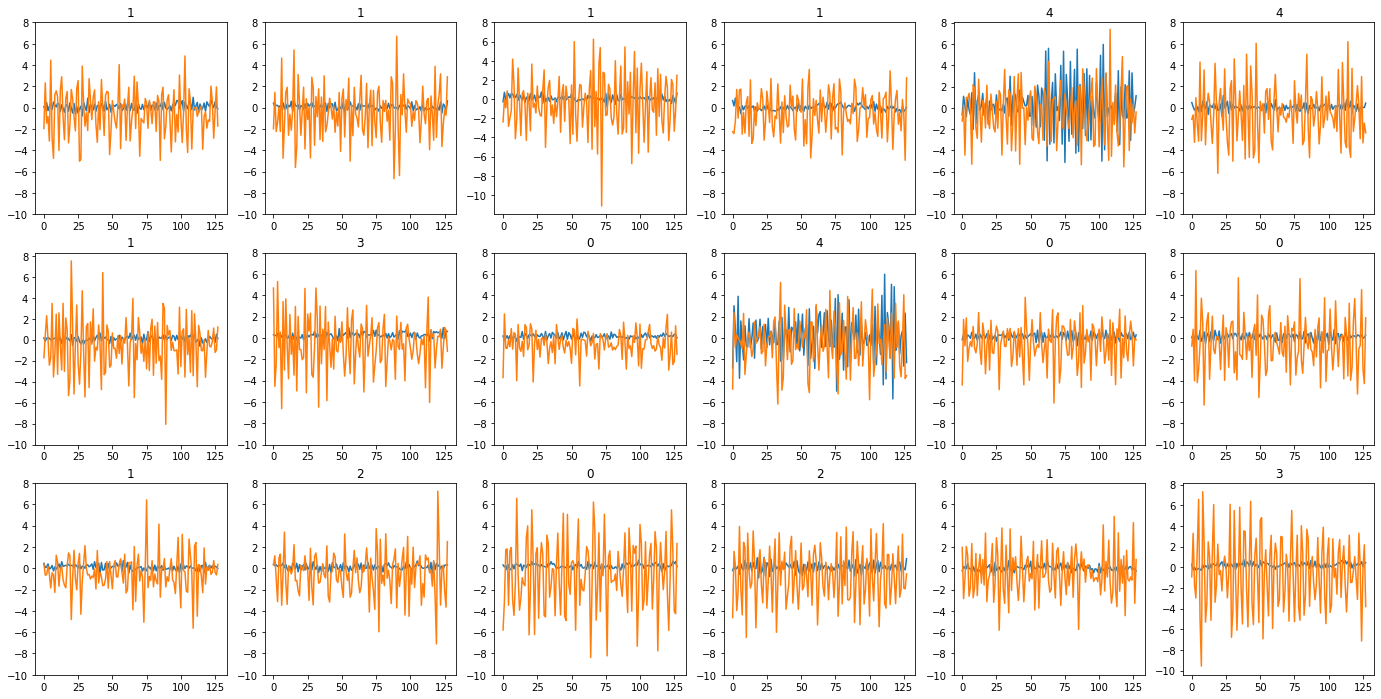

In [ ]:
rows = 3
cols = 6
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
for i, (audio, label) in enumerate(Dataset.unbatch().take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-10, 10, 2))
  label = int(label.numpy())#.decode('utf-8')
  ax.set_title(label)

In [ ]:
import  pywt
from scipy import fftpack

In [ ]:
Sample = list(Train_Dataset.unbatch().take(1).as_numpy_iterator())[0][0]

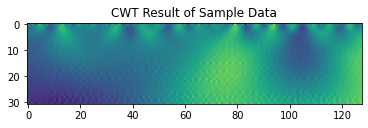

In [ ]:
coef, freqs = pywt.cwt(Sample ,np.arange(1,32), 'gaus1' , axis = 0)
plt.imshow(coef[:,:,0])
plt.title("CWT Result of Sample Data")
plt.show()

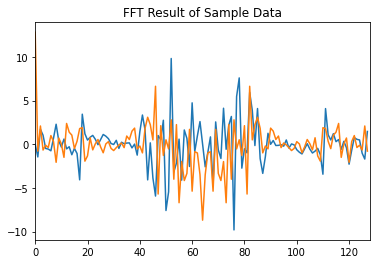

In [ ]:
imag = fftpack.fft(Sample[:,0]).imag
real = fftpack.fft(Sample[:,0]).real
plt.plot(imag)
plt.plot(real)
plt.xlim((0,128))
plt.title("FFT Result of Sample Data")
plt.show()

In [ ]:
CUSTOM_MODEL = keras.Sequential()
CUSTOM_MODEL.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[(128,2)]
      )
    )
)
CUSTOM_MODEL.add(keras.layers.Dropout(rate=0.5))
CUSTOM_MODEL.add(keras.layers.Dense(units=128, activation='relu'))
CUSTOM_MODEL.add(keras.layers.Dense(5, activation='softmax'))


CUSTOM_MODEL.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) # ANY CALLBACKS?


CUSTOM_MODEL.fit(Train_Dataset, epochs = 10, shuffle = True, validation_data = Valid_Dataset)

Epoch 1/10
8905/8905 [==============================] - 254s 28ms/step - loss: 0.1305 - accuracy: 0.9546 - val_loss: 0.0278 - val_accuracy: 0.9904
Epoch 2/10
8905/8905 [==============================] - 245s 27ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0112 - val_accuracy: 0.9964
Epoch 3/10
8905/8905 [==============================] - 245s 27ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.0053 - val_accuracy: 0.9984
Epoch 4/10
8905/8905 [==============================] - 246s 27ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0042 - val_accuracy: 0.9987
Epoch 5/10
8905/8905 [==============================] - 246s 27ms/step - loss: 0.0079 - accuracy: 0.9977 - val_loss: 0.0053 - val_accuracy: 0.9984
Epoch 6/10
8905/8905 [==============================] - 246s 27ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0075 - val_accuracy: 0.9983
Epoch 7/10
8905/8905 [==============================] - 245s 27ms/step - loss: 0.0051 - accuracy: 0.9985 - val_loss: 0

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/phmap_train/sample_submission_classification.csv')
final = pd.read_csv('/content/drive/MyDrive/phmap_train/final.csv').iloc[:,1:]
test_Dataset = TEST_Dataset_Constructor(final)


In [ ]:
pred = CUSTOM_MODEL.predict(test_Dataset)
a =np.argmax(pred,axis = 1)

In [ ]:
a

array([1, 4, 0, ..., 0, 1, 1])

In [ ]:
sub.iloc[:,1] = a


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0a9fcb590>]],
      dtype=object)

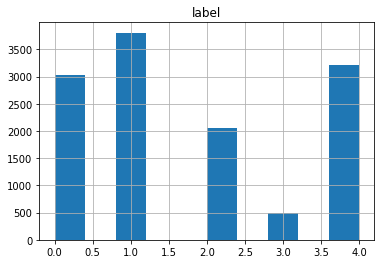

In [ ]:
pred=CUSTOM_MODEL.predict(test_Dataset)
a =np.argmax(pred,axis = 1)
sub.iloc[:,1] = a
sub.to_csv('/content/drive/MyDrive/CUSTOM_MODEL.csv', index = False)
sub.hist()

Train_Dataset -> (8905,256, 128,2)

In [ ]:
Train_Dataset

<SkipDataset shapes: ((None, 128, 2), (None,)), types: (tf.float64, tf.float64)>

In [ ]:
for waveform, label in Train_Dataset.take(1):
  Train_label = label
  Train_waveform = waveform
for waveform, label in Valid_Dataset.take(1):
  Valid_label = label
  Valid_waveform = waveform

In [ ]:
Train_label

<tf.Tensor: shape=(256,), dtype=float64, numpy=
array([1., 2., 0., 3., 2., 1., 3., 2., 4., 2., 1., 3., 4., 4., 2., 1., 0.,
       4., 0., 0., 3., 1., 0., 2., 0., 2., 2., 0., 1., 1., 1., 1., 3., 2.,
       1., 2., 2., 4., 4., 3., 2., 3., 4., 4., 0., 0., 2., 1., 1., 2., 2.,
       0., 4., 3., 1., 2., 3., 1., 3., 3., 1., 1., 3., 0., 4., 3., 1., 1.,
       4., 1., 3., 3., 4., 0., 2., 4., 3., 0., 4., 0., 2., 4., 4., 1., 0.,
       1., 1., 1., 2., 0., 3., 3., 3., 2., 3., 0., 4., 0., 4., 4., 0., 2.,
       1., 1., 1., 4., 0., 2., 2., 1., 0., 4., 0., 1., 2., 4., 3., 4., 3.,
       0., 0., 0., 0., 2., 0., 0., 1., 3., 4., 3., 3., 1., 1., 0., 3., 2.,
       1., 2., 3., 1., 3., 2., 0., 2., 1., 4., 4., 4., 4., 1., 2., 1., 0.,
       2., 3., 2., 4., 2., 4., 2., 4., 2., 1., 0., 2., 3., 2., 3., 3., 0.,
       0., 0., 4., 3., 1., 3., 3., 0., 1., 3., 2., 2., 1., 2., 4., 3., 3.,
       1., 3., 0., 4., 3., 0., 4., 4., 3., 2., 3., 2., 1., 1., 1., 3., 3.,
       1., 4., 1., 3., 2., 0., 3., 0., 3., 3., 4., 1

In [ ]:
d = []
l = []



In [ ]:
d

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [ ]:
data = d[0]

In [ ]:
for i in tqdm(range(1,100):
  

<tf.Tensor: shape=(256, 128, 2), dtype=float64, numpy=
array([[[-7.01015566e-01, -2.22739129e+00],
        [ 1.33636084e+00, -3.63251135e+00],
        [-1.20465997e+00,  9.06174273e-01],
        ...,
        [ 2.10228062e+00, -4.07845846e+00],
        [-1.28080751e-01,  1.72798831e+00],
        [ 9.66379867e-01, -2.44414360e+00]],

       [[ 1.46815904e-01,  3.74888208e-01],
        [ 2.82014155e-01, -9.06209476e-01],
        [ 4.32366890e-01, -1.12307264e-02],
        ...,
        [-6.86400117e-02,  2.02884084e-01],
        [ 2.01369061e-01, -1.41335566e+00],
        [-8.70727503e-02, -2.73251091e+00]],

       [[ 1.08445409e-01, -3.84518075e+00],
        [ 2.33540672e-01,  5.15887678e+00],
        [-6.86251106e-02, -2.60830972e+00],
        ...,
        [-2.19572605e-03,  8.71171441e-01],
        [ 1.83547270e-01,  4.70774407e+00],
        [ 2.50155469e-01,  8.99871081e-01]],

       ...,

       [[ 7.05192282e-01,  1.74919267e+00],
        [ 8.98892500e-01,  3.74590185e-01],
       

In [ ]:
tf.cast(d)

In [ ]:
l = tf.convert_to_tensor(l)

In [ ]:
Valid_waveform.shape

In [ ]:
Train_waveform.shape

In [ ]:
Train_Dataset.__len__().numpy()

In [ ]:
Train_coef,freq = pywt.cwt(Train_waveform.numpy() ,np.arange(1,32), 'gaus1' , axis = 1)
Valid_coef,freq = pywt.cwt(Valid_waveform.numpy() ,np.arange(1,32), 'gaus1' , axis = 1)


In [ ]:
plt.imshow(Train_coef[:,0,:,0])

In [ ]:
Train_coef = tf.transpose(Train_coef, (1, 0, 2, 3))
Valid_coef = tf.transpose(Valid_coef,(1, 0, 2, 3))

In [ ]:
Train_coef.shape


In [ ]:
Valid_coef.shape

In [ ]:
Train_coef[0,0,:,:].shape

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((Train_coef ,Train_label))

In [ ]:
train_ds.__len__().numpy()

In [ ]:
Train_label.shape

In [ ]:
valid_ds = tf.data.Dataset.from_tensor_slices((Valid_coef ,Valid_label))

In [ ]:
plt.imshow((Train_coef[0,:,:,0]))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
num_classes = 5

model = Sequential()
model.add(layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=( 31, 128, 2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)